In [1]:
import time
import utils

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from model import StyleContentModel

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

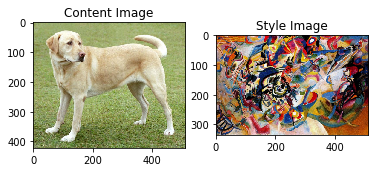

In [4]:
content_image = utils.load_img(content_path)
style_image = utils.load_img(style_path)

plt.subplot(1, 2, 1)
utils.imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
utils.imshow(style_image, 'Style Image')

## Define content and style representations

Use the intermediate layers of the model to get the content and style representations of the image.<br/>
Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. <br/>
As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. <br/>
In this case, we will use the VGG19 network architecture, a pretrained image classification network. <br/>
These intermediate layers are necessary to define the representation of content and style from the images. <br/>
For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [6]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [7]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

80142336/80134624 [==============================] - 21s 0us/step
Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228453
    max:  28014.555
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


### Run gradient descent

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a tf.Variable to contain the image to optimize. < br/>
To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image):

In [ ]:
image = tf.Variable(content_image)

In [ ]:
# clip values to stop the gradients from exploding

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

In [ ]:
# The paper recommends LBFGS, but Adam works okay, too:

opt = tf.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

In [ ]:
style_weight = 1e-2
content_weight = 1e4

In [ ]:
# MSE loss based on the combination of style_weight and content_weight

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use tf.GradientTape to update the image.

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
# Test after 1 epoch

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
# perform longer optimization over epochs

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

### Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts.< br/>
Decrease these using an explicit regularization term on the high frequency components of the image. <br/>
In style transfer, this is often called the total variation loss